In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
import cv2
from glob import glob
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
#from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
from PIL import Image
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


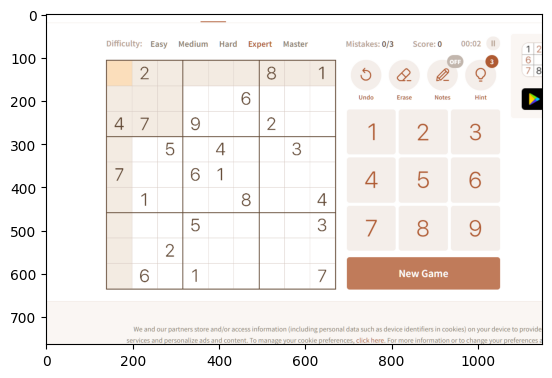

In [ ]:
puzzle = cv2.imread("/content/drive/My Drive/sample.png")

#sudoku image
plt.figure()
plt.imshow(puzzle)
plt.show()

In [ ]:
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3),6)
    #blur = cv2.bilateralFilter(gray,9,75,75)
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) ==4:
                biggest = approx
                max_area = area
    return biggest ,max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def splitcells(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes


black_img = np.zeros((450,450,3), np.uint8)

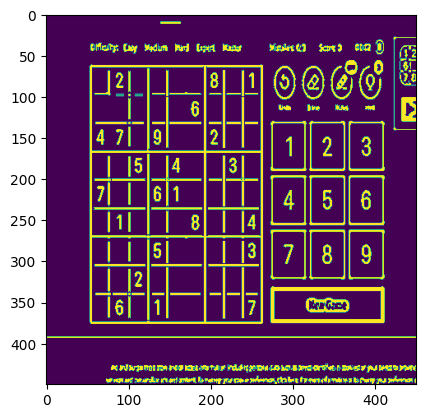

In [ ]:
# Resizing puzzle to be solved
puzzle = cv2.resize(puzzle, (450,450))
# Preprocessing Puzzle
su_puzzle = preprocess(puzzle)

# Preprocessing image to be read
plt.figure()
plt.imshow(su_puzzle)
plt.show()

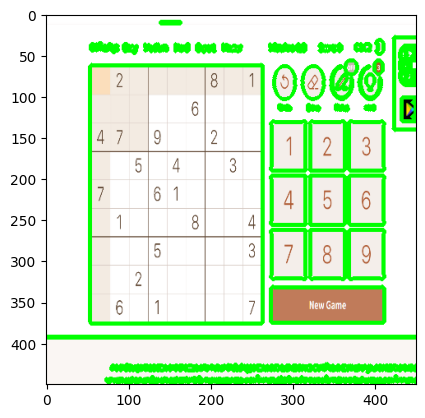

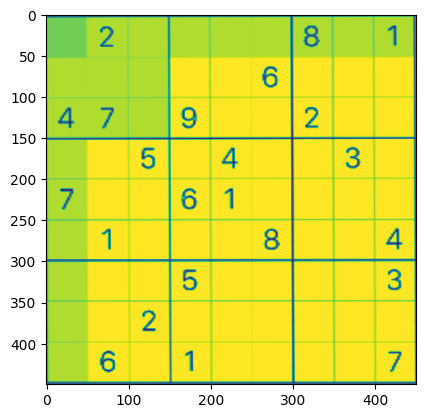

In [ ]:
# Finding the outline of the sudoku puzzle in the image
su_contour_1= puzzle.copy()
#su_contour_2= su_puzzle.copy()
su_contour, hierarchy = cv2.findContours(su_puzzle,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(su_contour_1, su_contour,-1,(0,255,0),3)

# outline of the sudoku puzzle in the image
plt.figure()
plt.imshow(su_contour_1)
plt.show()

black_img = np.zeros((450,450,3), np.uint8)
su_biggest, su_maxArea = main_outline(su_contour)
if su_biggest.size != 0:
    su_biggest = reframe(su_biggest)
    cv2.drawContours(su_contour_1,su_biggest,-1, (0,255,0),10)
    su_pts1 = np.float32(su_biggest)
    su_pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    su_matrix = cv2.getPerspectiveTransform(su_pts1,su_pts2)
    su_imagewrap = cv2.warpPerspective(puzzle,su_matrix,(450,450))
    su_imagewrap =cv2.cvtColor(su_imagewrap, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(su_imagewrap)
plt.show()

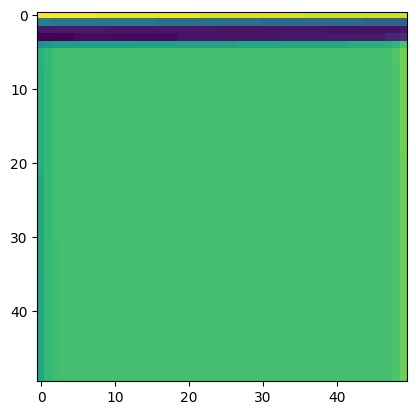

In [ ]:
sudoku_cell = splitcells(su_imagewrap)
# Splitting the sudoku box into 81 cells
plt.figure()
plt.imshow(sudoku_cell[0])
plt.show()

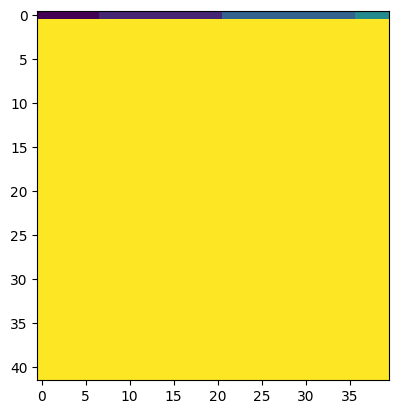

In [ ]:
def CropCell(cells):
    Cells_croped = []
    for image in cells:

        img = np.array(image)
        img = img[4:46, 6:46]
        img = Image.fromarray(img)
        Cells_croped.append(img)

    return Cells_croped

sudoku_cell_croped= CropCell(sudoku_cell)
# cropping the cells
plt.figure()
plt.imshow(sudoku_cell_croped[0])
plt.show()

In [ ]:
# Load the pre-trained model
model = load_model('/content/drive/My Drive/my_model_cv1.h5')

def read_cells(cell,model):

    result = []
    for image in cell:
        # preprocess the image as it was in the model
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (32, 32))
        img = img / 255
        img = img.reshape(1, 32, 32, 1)
        # getting predictions and setting the values if probabilities are above 65%

        # verbose=None is used to turn off the log of model prediction
        predictions = model.predict(img, verbose=None)
        #classIndex = model.predict_classes(img)
        predictions1 = np.argmax(predictions, axis=1)

        probabilityValue = np.amax(predictions)

        if probabilityValue > 0.65:
            result.append(predictions1[0])
        else:
            result.append(0)
    return result

grid = read_cells(sudoku_cell_croped, model)
grid = np.asarray(grid)

In [ ]:
# Reshaping the grid to a 9x9 matrix
grid = np.reshape(grid,(9,9))
grid

array([[0, 2, 0, 0, 0, 0, 8, 0, 1],
       [0, 0, 0, 0, 0, 6, 0, 0, 0],
       [4, 7, 0, 9, 0, 0, 2, 0, 0],
       [0, 0, 5, 0, 4, 0, 0, 3, 0],
       [7, 0, 0, 6, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 8, 0, 0, 4],
       [0, 0, 0, 5, 0, 0, 0, 0, 3],
       [0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 1, 0, 0, 0, 0, 7]])

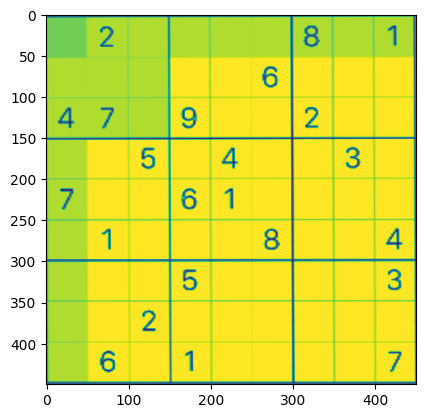

In [ ]:
#For compare
plt.figure()
plt.imshow(su_imagewrap)
plt.show()

In [ ]:
def next_box(quiz):
    for row in range(9):
        for col in range(9):
            if quiz[row][col] == 0:
                return (row, col)
    return False


def possible (quiz, row, col, n):
    #global quiz
    for i in range (0,9):
        if quiz[row][i] == n and row != i:
            return False
    for i in range (0,9):
        if quiz[i][col] == n and col != i:
            return False

    row0 = (row)//3
    col0 = (col)//3
    for i in range(row0*3, row0*3 + 3):
        for j in range(col0*3, col0*3 + 3):
            if quiz[i][j]==n and (i,j) != (row, col):
                return False
    return True

#Recursion function to loop over untill a valid answer is found.

def solve(quiz):
    val = next_box(quiz)
    if val is False:
        return True
    else:
        row, col = val
        for n in range(1,10): #n is the possible solution
            if possible(quiz,row, col, n):
                quiz[row][col]=n
                if solve(quiz):
                    return True
                else:
                    quiz[row][col]=0
        return

def Solved(quiz):
    for row in range(9):
        if row % 3 == 0 and row != 0:
            print(".....................")

        for col in range(9):
            if col % 3 == 0 and col != 0:
                print("|", end=" ")

            if col == 8:
                print(quiz[row][col])
            else:
                print(str(quiz[row][col]) + " ", end="")

In [ ]:
solve(grid)

True

In [ ]:
if solve(grid):
    Solved(grid)
else:
    print("Solution don't exist. Model misread digits.")

3 2 6 | 3 5 7 | 8 4 1
5 9 1 | 4 2 6 | 3 7 9
4 7 8 | 9 1 8 | 2 6 5
.....................
2 8 5 | 7 4 9 | 1 3 6
7 3 4 | 6 1 5 | 9 8 2
6 1 9 | 2 3 8 | 7 5 4
.....................
1 4 7 | 5 8 2 | 6 9 3
9 5 2 | 7 6 3 | 4 1 8
3 6 8 | 1 9 4 | 5 2 7
